In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Library Installations and Imports

In [50]:
# Install Google Play Scraper
!pip install google_play_scraper

In [51]:
# Install App Store Scraper
!pip install app-store-scraper

In [85]:
# Imports
import json
from tqdm import tqdm
from datetime import datetime, date, timedelta
from pprint import pprint

# Google Play
from google_play_scraper import Sort, reviews, app

# App Store
from app_store_scraper import AppStore

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Tables
from tabulate import tabulate

## Scraping Reviews from Google Play Store

In [53]:
# Specify the app
app_packages=['com.square_enix.android_googleplay.FFVIII']

# Initialize a blank list to hold all the reviews
playstore_reviews=[]

In [54]:
# Looping to scrape the reviews
for ap in tqdm(app_packages):
    # Low score = 1, high score = 5
    for score in list(range(1, 6)):
        # Sort from new to old
        for sort_order in [Sort.NEWEST]:
            # Review components
            rvs, _ = reviews(ap, 
                                 sort = sort_order, 
                                 count = 1000, 
                                 filter_score_with = score)
            # Iterate through reviews gathered
            for r in rvs:
                r['sortOrder'] = 'newest'
                r['AppId'] = ap
            # Add new review to list
            playstore_reviews.extend(rvs)

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


In [55]:
# Check gathered contents
playstore_reviews[50]

{'reviewId': '6f2edd4f-ad80-483e-a41b-78b060882dfa',
 'userName': 'Brian Howard',
 'userImage': 'https://play-lh.googleusercontent.com/a-/AFdZucop-pg-cjtJw5eEtc5bAP4wnYeSzz9pKuDH61c',
 'content': 'App doesnt work right',
 'score': 1,
 'thumbsUpCount': 0,
 'reviewCreatedVersion': '1.0.0 (210309)',
 'at': datetime.datetime(2021, 4, 19, 18, 4, 49),
 'replyContent': None,
 'repliedAt': None,
 'sortOrder': 'newest',
 'AppId': 'com.square_enix.android_googleplay.FFVIII'}

From the above display it appears that all of the relevant data has been collected. 

In [56]:
# Create a dataframe only for reviews from the Google Play Store
google_play_reviews = pd.DataFrame(playstore_reviews)

# Drop duplicates
google_play_reviews = google_play_reviews.drop_duplicates(keep = 'first')

# Check
google_play_reviews.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,AppId
0,5ba25ca1-6bb0-4a28-8db5-b9286f46d5cc,Jack Agresti,https://play-lh.googleusercontent.com/a-/AFdZu...,"Played FFVII and IX, they played just fine. My...",1,1,1.0.1,2022-07-26 11:44:45,None,None,newest,com.square_enix.android_googleplay.FFVIII
1,4803f991-793b-4574-af77-52b3c7c51099,Justice Peralta,https://play-lh.googleusercontent.com/a-/AFdZu...,Bad aspect ratio and flubbed on-screen controls.,1,0,None,2022-07-16 09:06:41,None,None,newest,com.square_enix.android_googleplay.FFVIII
2,8b215996-c5d8-4cd5-8b43-e2dbf7da2c24,Brian Puckett,https://play-lh.googleusercontent.com/a-/AFdZu...,"Game runs great for about 5 minutes, then you ...",1,0,1.0.1,2022-07-09 21:07:57,None,None,newest,com.square_enix.android_googleplay.FFVIII
3,e1d302de-30fa-47f3-bb49-136cc378bc84,B B,https://play-lh.googleusercontent.com/a/AItbvm...,Any updates on this? Why can I install final f...,1,1,1.0.1,2022-06-17 18:15:38,None,None,newest,com.square_enix.android_googleplay.FFVIII
4,c05044c7-35b3-4f3b-8d5d-6fe733f006ee,James Small,https://play-lh.googleusercontent.com/a-/AFdZu...,My favorite FF but this seriously needs fixing...,1,2,1.0.1,2022-05-29 17:13:56,None,None,newest,com.square_enix.android_googleplay.FFVIII


In [57]:
# Get information about the gathered reviews
google_play_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              335 non-null    object        
 1   userName              335 non-null    object        
 2   userImage             335 non-null    object        
 3   content               335 non-null    object        
 4   score                 335 non-null    int64         
 5   thumbsUpCount         335 non-null    int64         
 6   reviewCreatedVersion  299 non-null    object        
 7   at                    335 non-null    datetime64[ns]
 8   replyContent          0 non-null      object        
 9   repliedAt             0 non-null      object        
 10  sortOrder             335 non-null    object        
 11  AppId                 335 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 34.0+ KB


In [58]:
# Summarize the unique values for specific columns
gp_cols = google_play_reviews.columns

# Iterate through the list of columns
for c in range(1,len(gp_cols)):
    if (gp_cols[c] == 'score') | (gp_cols[c] == 'reviewCreatedVersion') | (gp_cols[c] == 'replyContent') | (gp_cols[c] == 'repliedAt'):
        # Print the unique values per column
        print(f"{gp_cols[c]} unique values: {google_play_reviews[gp_cols[c]].unique()}")

score unique values: [1 2 3 4 5]
reviewCreatedVersion unique values: ['1.0.1' None '1.0.0 (210309)']
replyContent unique values: [None]
repliedAt unique values: [None]


## Scraping Reviews from AppStore

In [59]:
# Specify the app reviews to scrape
ff8_app = AppStore(country="us", app_name="final-fantasy-viii-remastered", app_id=1326740784)

# Specify the number of reviews
ff8_app.review(how_many=1000, sleep=25)

# Show how many reviews were actually received
print(f"There were {ff8_app.reviews_count} reviews scraped.")

There were 98 reviews scraped.


In [60]:
# Data frame of only App Store reviews
app_store_reviews=pd.DataFrame(ff8_app.reviews)

# Drop duplicates
app_store_reviews = app_store_reviews.drop_duplicates(keep='first')

# Check
app_store_reviews.head()

,isEdited,review,rating,userName,title,date
0,False,I have been waiting for this to come out for i...,4,Rxdrummer,"Great Port, with One Flaw",2021-05-01 19:31:13
1,False,"Wow, what a trip down memory lane! I’ve been w...",5,KittenMoney,"A million times, thank you!",2021-03-25 12:47:16
2,False,This is by far my favorite final fantasy out o...,2,Sirdracoblight,"Favorite Final Fantasy, but underwhelmed.",2021-09-18 04:11:58
3,False,It's difficult to give this a fair review part...,3,IsthereAnicknameathatIsntTaken,Having trouble starting,2021-03-29 16:12:20
4,False,This game is an excellent port of a classic RP...,3,ianfloresta,"Excellent, but desperately needs controller su...",2021-04-26 22:26:38


In [61]:
# Add the app id as an identifier once the dataframes are merged
app_store_reviews['AppId'] = 1326740784

# Check
app_store_reviews.head()

,isEdited,review,rating,userName,title,date,AppId
0,False,I have been waiting for this to come out for i...,4,Rxdrummer,"Great Port, with One Flaw",2021-05-01 19:31:13,1326740784
1,False,"Wow, what a trip down memory lane! I’ve been w...",5,KittenMoney,"A million times, thank you!",2021-03-25 12:47:16,1326740784
2,False,This is by far my favorite final fantasy out o...,2,Sirdracoblight,"Favorite Final Fantasy, but underwhelmed.",2021-09-18 04:11:58,1326740784
3,False,It's difficult to give this a fair review part...,3,IsthereAnicknameathatIsntTaken,Having trouble starting,2021-03-29 16:12:20,1326740784
4,False,This game is an excellent port of a classic RP...,3,ianfloresta,"Excellent, but desperately needs controller su...",2021-04-26 22:26:38,1326740784


In [62]:
# Get shape
app_store_reviews.shape

(98, 7)

In [63]:
# Get basic info about the dataframe
app_store_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   isEdited  98 non-null     bool          
 1   review    98 non-null     object        
 2   rating    98 non-null     int64         
 3   userName  98 non-null     object        
 4   title     98 non-null     object        
 5   date      98 non-null     datetime64[ns]
 6   AppId     98 non-null     int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 5.5+ KB


In [64]:
# Unique values
print(app_store_reviews.rating.unique())
print(app_store_reviews.isEdited.unique())

[4 5 2 3 1]
[False]


There is some similarity between the data returned by the two different scrapers.

Google Play Results   |   App Store Results
----------------------|--------------------
userName              |   userName
content               |   review
score                 |   rating
at                    |   date
AppId                 |   AppId

The extra columns from the dataframe of google play results will be dropped, in addition to any unneeded columns from both dataframes:
- userName
- isEdited
- replyContent
- repliedAt
- sortOrder
- thumbsUpCount
- reviewCreatedVersion
- title

The remaining columns between the two data frames will then be renamed.
- content --> review
- score --> rating
- at --> date

## Cleaning up the Data Frames

In [65]:
# Google play dataframe
google_play_reviews.drop(['userName', 'replyContent', 'repliedAt', 'reviewId', 'userImage', 'thumbsUpCount','reviewCreatedVersion', 'sortOrder'], axis=1, inplace=True)

# Check
google_play_reviews.head()

,content,score,at,AppId
0,"Played FFVII and IX, they played just fine. My...",1,2022-07-26 11:44:45,com.square_enix.android_googleplay.FFVIII
1,Bad aspect ratio and flubbed on-screen controls.,1,2022-07-16 09:06:41,com.square_enix.android_googleplay.FFVIII
2,"Game runs great for about 5 minutes, then you ...",1,2022-07-09 21:07:57,com.square_enix.android_googleplay.FFVIII
3,Any updates on this? Why can I install final f...,1,2022-06-17 18:15:38,com.square_enix.android_googleplay.FFVIII
4,My favorite FF but this seriously needs fixing...,1,2022-05-29 17:13:56,com.square_enix.android_googleplay.FFVIII


In [66]:
# Column rename mapper
gp_col_mapper={'content': 'review',
               'score': 'rating',
               'at': 'date'}

# Rename columns in google_play_reviews
google_play_reviews.rename(columns=gp_col_mapper, inplace=True)

# Check
google_play_reviews.head()

,review,rating,date,AppId
0,"Played FFVII and IX, they played just fine. My...",1,2022-07-26 11:44:45,com.square_enix.android_googleplay.FFVIII
1,Bad aspect ratio and flubbed on-screen controls.,1,2022-07-16 09:06:41,com.square_enix.android_googleplay.FFVIII
2,"Game runs great for about 5 minutes, then you ...",1,2022-07-09 21:07:57,com.square_enix.android_googleplay.FFVIII
3,Any updates on this? Why can I install final f...,1,2022-06-17 18:15:38,com.square_enix.android_googleplay.FFVIII
4,My favorite FF but this seriously needs fixing...,1,2022-05-29 17:13:56,com.square_enix.android_googleplay.FFVIII


In [67]:
# Reorder google_play_reviews columns
google_play_reviews = google_play_reviews[['rating', 'date', 'review', 'AppId']]

# Check
google_play_reviews.head()

,rating,date,review,AppId
0,1,2022-07-26 11:44:45,"Played FFVII and IX, they played just fine. My...",com.square_enix.android_googleplay.FFVIII
1,1,2022-07-16 09:06:41,Bad aspect ratio and flubbed on-screen controls.,com.square_enix.android_googleplay.FFVIII
2,1,2022-07-09 21:07:57,"Game runs great for about 5 minutes, then you ...",com.square_enix.android_googleplay.FFVIII
3,1,2022-06-17 18:15:38,Any updates on this? Why can I install final f...,com.square_enix.android_googleplay.FFVIII
4,1,2022-05-29 17:13:56,My favorite FF but this seriously needs fixing...,com.square_enix.android_googleplay.FFVIII


In [68]:
# App store dataframe
app_store_reviews.drop(['isEdited', 'userName', 'title'], axis=1, inplace=True)

# Check
app_store_reviews.head()

,review,rating,date,AppId
0,I have been waiting for this to come out for i...,4,2021-05-01 19:31:13,1326740784
1,"Wow, what a trip down memory lane! I’ve been w...",5,2021-03-25 12:47:16,1326740784
2,This is by far my favorite final fantasy out o...,2,2021-09-18 04:11:58,1326740784
3,It's difficult to give this a fair review part...,3,2021-03-29 16:12:20,1326740784
4,This game is an excellent port of a classic RP...,3,2021-04-26 22:26:38,1326740784


In [69]:
# Merge dataframes
all_reviews_df=pd.concat([google_play_reviews, app_store_reviews])

# Check
all_reviews_df.head()

,rating,date,review,AppId
0,1,2022-07-26 11:44:45,"Played FFVII and IX, they played just fine. My...",com.square_enix.android_googleplay.FFVIII
1,1,2022-07-16 09:06:41,Bad aspect ratio and flubbed on-screen controls.,com.square_enix.android_googleplay.FFVIII
2,1,2022-07-09 21:07:57,"Game runs great for about 5 minutes, then you ...",com.square_enix.android_googleplay.FFVIII
3,1,2022-06-17 18:15:38,Any updates on this? Why can I install final f...,com.square_enix.android_googleplay.FFVIII
4,1,2022-05-29 17:13:56,My favorite FF but this seriously needs fixing...,com.square_enix.android_googleplay.FFVIII


In [70]:
# Info from merged dataframe
all_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 433 entries, 0 to 97
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   rating  433 non-null    int64         
 1   date    433 non-null    datetime64[ns]
 2   review  433 non-null    object        
 3   AppId   433 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 16.9+ KB


In [71]:
# Generate a csv file
#all_reviews_df.to_csv('ff8_app_reviews', index=False)

# Non-Text Data Investigation

## Rating Data

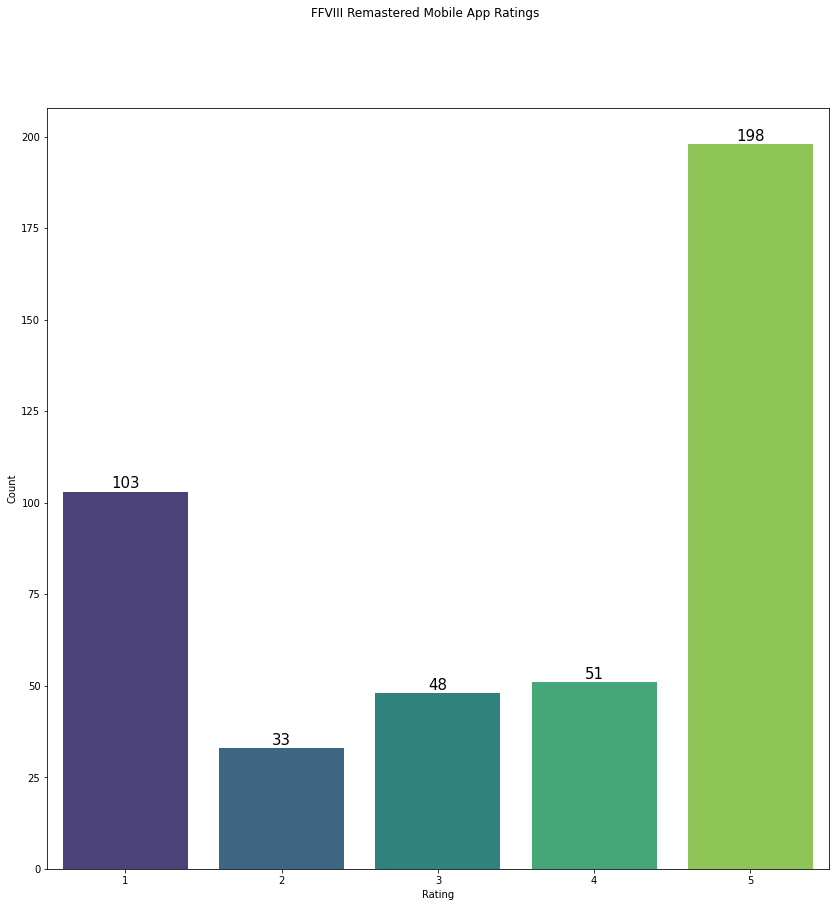

In [98]:
# Chart distribution of ratings
fig, ax=plt.subplots(figsize=(14,14))

# Chart
sns.countplot(data=all_reviews_df, x='rating', palette='viridis')
fig.suptitle('FFVIII Remastered Mobile App Ratings') # Title
ax.set_xlabel('Rating') # X-Axis title
ax.set_ylabel('Count') # Y-Axis title

# Bar annotations
for p in ax.patches:
    ax.annotate(format(p.get_height()),
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', 
                va='center',
                size=15, 
                xytext=(0, 8),
                textcoords='offset points')

# Show
plt.show()

## Date and Time Data

In [99]:
# Split date and time into two columns
all_reviews_df.insert(2, 'date_stamp', pd.to_datetime(all_reviews_df['date']).dt.date) # Date
all_reviews_df.insert(3, 'time_stamp', pd.to_datetime(all_reviews_df['date']).dt.time) # Time

# Check
all_reviews_df.head()

,rating,date,date_stamp,time_stamp,review,AppId
0,1,2022-07-26 11:44:45,2022-07-26,11:44:45,"Played FFVII and IX, they played just fine. My...",com.square_enix.android_googleplay.FFVIII
1,1,2022-07-16 09:06:41,2022-07-16,09:06:41,Bad aspect ratio and flubbed on-screen controls.,com.square_enix.android_googleplay.FFVIII
2,1,2022-07-09 21:07:57,2022-07-09,21:07:57,"Game runs great for about 5 minutes, then you ...",com.square_enix.android_googleplay.FFVIII
3,1,2022-06-17 18:15:38,2022-06-17,18:15:38,Any updates on this? Why can I install final f...,com.square_enix.android_googleplay.FFVIII
4,1,2022-05-29 17:13:56,2022-05-29,17:13:56,My favorite FF but this seriously needs fixing...,com.square_enix.android_googleplay.FFVIII


In [100]:
# Drop date
all_reviews_df.drop(['date'], axis=1, inplace=True)

# Check
all_reviews_df.head()

,rating,date_stamp,time_stamp,review,AppId
0,1,2022-07-26,11:44:45,"Played FFVII and IX, they played just fine. My...",com.square_enix.android_googleplay.FFVIII
1,1,2022-07-16,09:06:41,Bad aspect ratio and flubbed on-screen controls.,com.square_enix.android_googleplay.FFVIII
2,1,2022-07-09,21:07:57,"Game runs great for about 5 minutes, then you ...",com.square_enix.android_googleplay.FFVIII
3,1,2022-06-17,18:15:38,Any updates on this? Why can I install final f...,com.square_enix.android_googleplay.FFVIII
4,1,2022-05-29,17:13:56,My favorite FF but this seriously needs fixing...,com.square_enix.android_googleplay.FFVIII


### Split Date: Year-Month-Day